# 租金预测

这个项目用于研究并预测某地的房屋租金。

In [327]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
%matplotlib inline

In [328]:
plt.rcParams['font.sans-serif'] = ['SimHei'] # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False   # 步骤二（解决坐标轴负数的负号显示问题）

## 数据分析

In [329]:
df_train = pd.read_csv('./Datasets/train.csv')
df_train.head()

,rent_approval_date,town,block,street_name,flat_type,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent
0,2021-09,jurong east,257,Jurong East Street 24,3 room,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600
1,2022-05,bedok,119,bedok north road,4-room,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region,2250
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100


根据训练集中房屋的位置和租金信息，可以大致了解不同地区租金的范围。

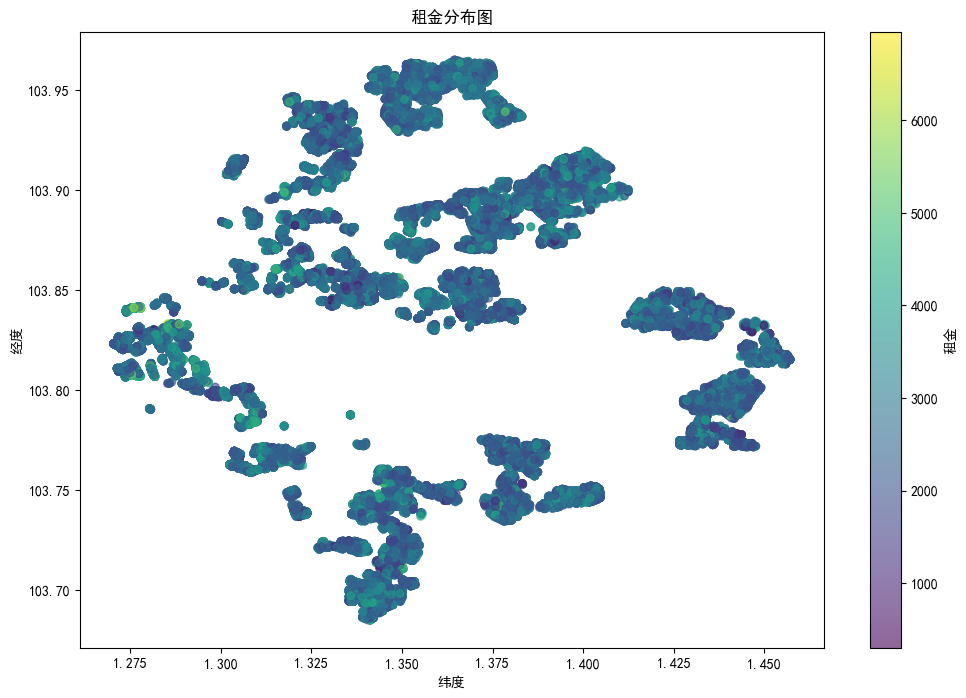

In [330]:
plt.figure(figsize=(12, 8))
plt.scatter(df_train['latitude'], df_train['longitude'], c=df_train['monthly_rent'], cmap='viridis', s=30, alpha=0.6)
plt.colorbar(label='租金')
plt.xlabel('纬度')
plt.ylabel('经度')
plt.title('租金分布图')
plt.show()

可以发现不同地区的租金范围大致相同，并没有出现某个地区的租金远低于或超出其它地区。

### 商场分布

In [331]:
shopping_malls = pd.read_csv('./Datasets/shopping-malls.csv')
shopping_malls.head()

,name,latitude,longitude
0,100 AM,1.274588,103.843471
1,313@Somerset,1.301385,103.837684
2,Aperia,1.310867,103.863930
3,Balestier Hill Shopping Centre,1.325596,103.842572
4,Bugis Cube,1.298141,103.855635


在图上标记出所有商场的位置。

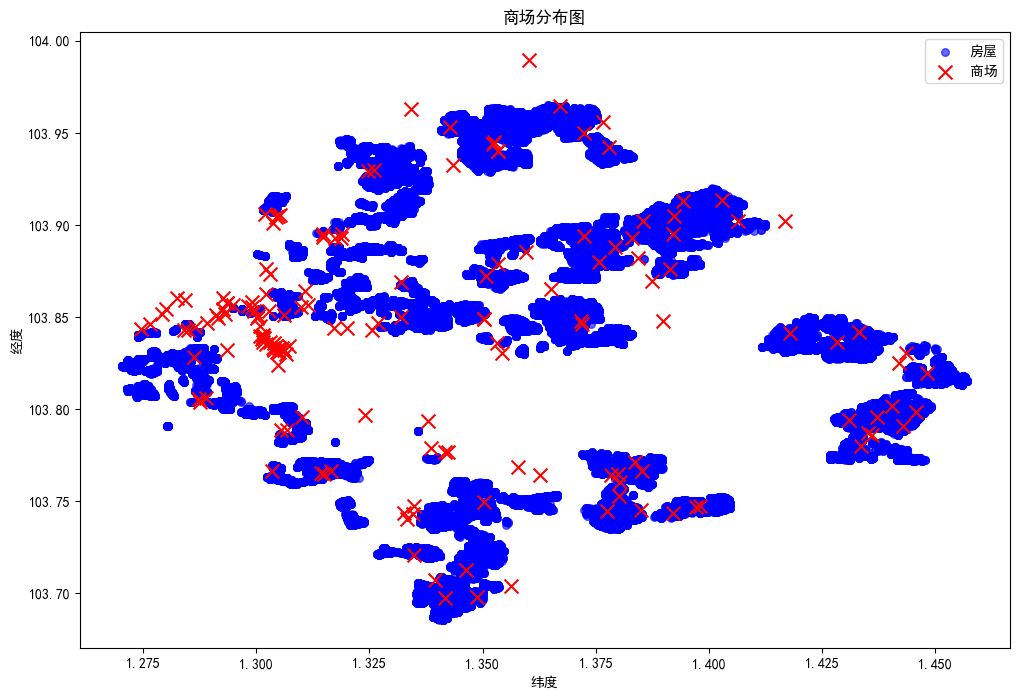

In [332]:
plt.figure(figsize=(12, 8))
plt.scatter(df_train['latitude'], df_train['longitude'], c='blue', s=30, alpha=0.6, label='房屋')
plt.scatter(shopping_malls['latitude'], shopping_malls['longitude'], c='red', marker='x', s=100, label='商场')
plt.xlabel('纬度')
plt.ylabel('经度')
plt.title('商场分布图')
plt.legend()
plt.show()

大部分的地区周边都有2个以上的商场，大量商场主要集中在西边的地区。

### 小学分布

In [333]:
primary_schools = pd.read_csv('./Datasets/primary-schools.csv')
primary_schools.head()

,name,latitude,longitude
0,Admiralty Primary School,1.454038,103.817436
1,Ahmad Ibrahim Primary School,1.433153,103.832942
2,Ai Tong School,1.360583,103.833020
3,Alexandra Primary School,1.291334,103.824425
4,Anchor Green Primary School,1.390370,103.887165


在图上标记出所有小学的位置。

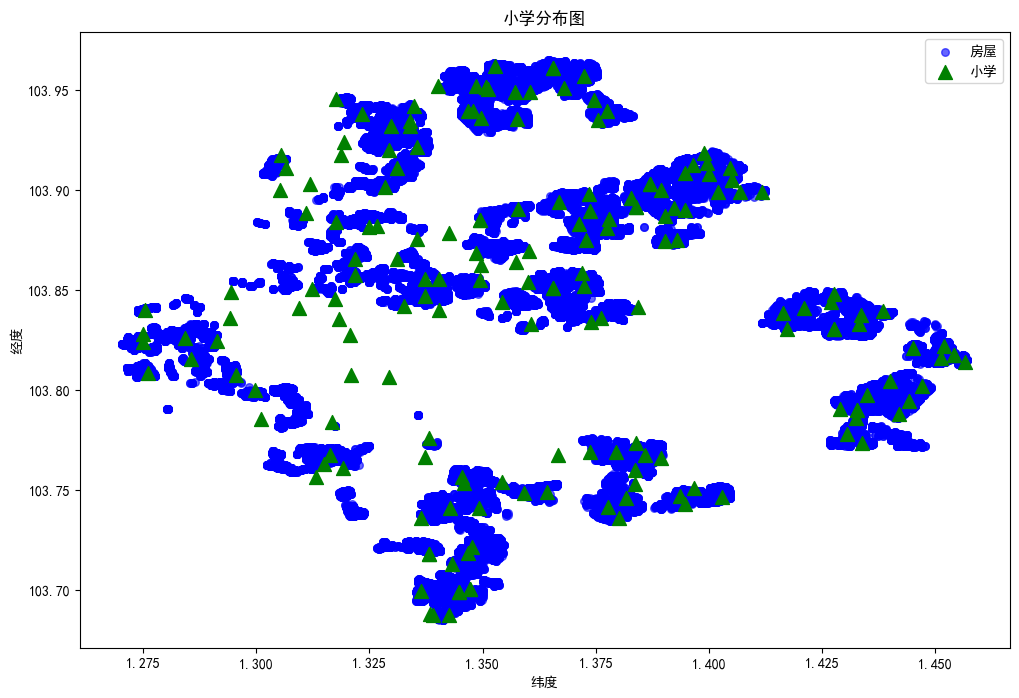

In [334]:
plt.figure(figsize=(12, 8))
plt.scatter(df_train['latitude'], df_train['longitude'], c='blue', s=30, alpha=0.6, label='房屋')
plt.scatter(primary_schools['latitude'], primary_schools['longitude'], c='green', marker='^', s=100, label='小学')
plt.xlabel('纬度')
plt.ylabel('经度')
plt.title('小学分布图')
plt.legend()
plt.show()

小学的分布相比商场更加均匀，各个地区都有至少5个以上的小学。

## 数据清洗

In [335]:
df_train.head()

,rent_approval_date,town,block,street_name,flat_type,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent
0,2021-09,jurong east,257,Jurong East Street 24,3 room,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600
1,2022-05,bedok,119,bedok north road,4-room,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region,2250
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100


经度`longitude`和纬度`latitude`已经足够表示房屋的地理位置，因此训练集中其它表示地理位置的信息可以不再需要，例如`town`、`block`、`street_name`、`subzone`、`planning_area`、`region`。

由于训练集中所有的`elevation`和`furnished`的值都相同，它们对分析无法提供任何帮助，因此也可以删除。

In [336]:
columns_to_drop = ['town', 'block', 'street_name', 'furnished', 'elevation', 'subzone', 'planning_area', 'region']
df_train.drop(columns_to_drop, axis=1, inplace=True)
df_train.head()

,rent_approval_date,flat_type,floor_area_sqm,lease_commence_date,latitude,longitude,monthly_rent
0,2021-09,3 room,67.0,1983,1.344518,103.738630,1600
1,2022-05,4-room,92.0,1978,1.330186,103.938717,2250
2,2022-10,3-room,67.0,1971,1.332242,103.845643,1900
3,2021-08,executive,149.0,1993,1.370239,103.962894,2850
4,2022-11,3-room,68.0,1972,1.320502,103.863341,2100


`flat_type`这列中的数据格式不统一，例如`3 room`和`3-room`其实是同样的房型。

In [337]:
df_train['flat_type'].unique()

array(['3 room', '4-room', '3-room', 'executive', '5 room', '4 room',
       '5-room', '2-room', '2 room'], dtype=object)

In [338]:
df_train['flat_type'] = df_train['flat_type'].replace({
    '2 room': '2-room',
    '3 room': '3-room',
    '4 room': '4-room',
    '5 room': '5-room',
})
df_train['flat_type'].unique()

array(['3-room', '4-room', 'executive', '5-room', '2-room'], dtype=object)

一般而言，卧室数量越多，房屋的租金也会越贵。因此`2-room`、`3-room`、`4-room`、`5-room`可以方便地转换为数值。

但是行政标间`executive`与其它房型没有普遍规律。在经过对比后，发现`executive`的租金与`5-room`最接近，因此，可以把`executive`简单地看作是`5-room`。

In [339]:
df_train['flat_type'] = df_train['flat_type'].map({
    '2-room': 2,
    '3-room': 3,
    '4-room': 4,
    '5-room': 5,
    'executive': 5,
})
df_train[['flat_type']].head()

,flat_type
0,3
1,4
2,3
3,5
4,3


In [340]:
df_train.head()

,rent_approval_date,flat_type,floor_area_sqm,lease_commence_date,latitude,longitude,monthly_rent
0,2021-09,3,67.0,1983,1.344518,103.738630,1600
1,2022-05,4,92.0,1978,1.330186,103.938717,2250
2,2022-10,3,67.0,1971,1.332242,103.845643,1900
3,2021-08,5,149.0,1993,1.370239,103.962894,2850
4,2022-11,3,68.0,1972,1.320502,103.863341,2100


将租金生效日期`rent_approval_date`拆分为`rent_approval_year`和`rent_approval_month`会更方便模型进行分析。

In [341]:
df_train = df_train.copy()

df_train['rent_approval_year'] = pd.DatetimeIndex(df_train['rent_approval_date']).year
df_train['rent_approval_month'] = pd.DatetimeIndex(df_train['rent_approval_date']).month
df_train.drop('rent_approval_date', axis=1, inplace=True)

df_train[['rent_approval_year', 'rent_approval_month']].head()

,rent_approval_year,rent_approval_month
0,2021,9
1,2022,5
2,2022,10
3,2021,8
4,2022,11


### 数据清洗函数

为了方便后续操作，将以上数据预处理的操作整合为一个函数。

In [342]:
def preprocessing(df):
    df = df.copy()

    columns_to_drop = ['town', 'block', 'street_name', 'furnished', 'elevation', 'subzone', 'planning_area', 'region']
    df.drop(columns_to_drop, axis=1, inplace=True)

    df['flat_type'] = df['flat_type'].replace({
        '2 room': '2-room',
        '3 room': '3-room',
        '4 room': '4-room',
        '5 room': '5-room',
    })

    df['flat_type'] = df['flat_type'].map({
        '2-room': 2,
        '3-room': 3,
        '4-room': 4,
        '5-room': 5,
        'executive': 5,
    })

    df['rent_approval_year'] = pd.DatetimeIndex(df['rent_approval_date']).year
    df['rent_approval_month'] = pd.DatetimeIndex(df['rent_approval_date']).month
    df.drop('rent_approval_date', axis=1, inplace=True)
    
    return df

## 合并辅助信息

将商场和小学的位置信息添加到训练集中有助于提高模型预测的准确性。

KNN算法可以用于计算房屋周边商场和小学的数量和距离。

这里将考察房屋方圆2km内的商场和小学。在训练集中将会添加：

1. `num_of_shopping_malls`：表示周边商场数量
2. `distance_to_nearest_shopping_mall`：到最近商场的距离
3. `num_of_primary_schools`：表示周边小学数量
4. `distance_to_nearest_primary_school`：到最近小学的距离

根据经纬度信息和实际距离，可以大致计算出比例尺。

In [343]:
km_scale = lambda km: km * 0.00552
km_radius = 2

### 商场

In [344]:
knn = NearestNeighbors(radius=km_scale(km_radius))
knn.fit(shopping_malls[['latitude', 'longitude']])
indices_train = knn.radius_neighbors(df_train[['latitude', 'longitude']], return_distance=False)
df_train['num_of_shopping_malls'] = [len(indices) for indices in indices_train]

In [345]:
knn = NearestNeighbors(n_neighbors=1)
knn.fit(shopping_malls[['latitude', 'longitude']])
distances_train, _ = knn.kneighbors(df_train[['latitude', 'longitude']])
df_train['distance_to_nearest_shopping_mall'] = distances_train.flatten()

In [346]:
df_train[['num_of_shopping_malls', 'distance_to_nearest_shopping_mall']].head()

,num_of_shopping_malls,distance_to_nearest_shopping_mall
0,1,0.010816
1,2,0.010024
2,3,0.004213
3,2,0.003619
4,1,0.009653


### 小学

In [347]:
knn = NearestNeighbors(radius=km_scale(km_radius))
knn.fit(primary_schools[['latitude', 'longitude']])
indices_train = knn.radius_neighbors(df_train[['latitude', 'longitude']], return_distance=False)
df_train['num_of_primary_schools'] = [len(indices) for indices in indices_train]

In [348]:
knn = NearestNeighbors(n_neighbors=1)
knn.fit(primary_schools[['latitude', 'longitude']])
distances_train, _ = knn.kneighbors(df_train[['latitude', 'longitude']])
df_train['distance_to_nearest_primary_school'] = distances_train.flatten()

In [349]:
df_train[['num_of_primary_schools', 'distance_to_nearest_primary_school']].head()

,num_of_primary_schools,distance_to_nearest_primary_school
0,3,0.003012
1,5,0.005466
2,3,0.003830
3,3,0.005081
4,3,0.002444


至此，我们得到了一个经过预处理的数据集。

In [350]:
df_train.head()

,flat_type,floor_area_sqm,lease_commence_date,latitude,longitude,monthly_rent,rent_approval_year,rent_approval_month,num_of_shopping_malls,distance_to_nearest_shopping_mall,num_of_primary_schools,distance_to_nearest_primary_school
0,3,67.0,1983,1.344518,103.738630,1600,2021,9,1,0.010816,3,0.003012
1,4,92.0,1978,1.330186,103.938717,2250,2022,5,2,0.010024,5,0.005466
2,3,67.0,1971,1.332242,103.845643,1900,2022,10,3,0.004213,3,0.003830
3,5,149.0,1993,1.370239,103.962894,2850,2021,8,2,0.003619,3,0.005081
4,3,68.0,1972,1.320502,103.863341,2100,2022,11,1,0.009653,3,0.002444


### 合并辅助信息函数

为了方便后续操作，将以上合并商场和小学信息的操作整合为函数。

In [351]:
def integrate_shopping_mall(df):
    shopping_malls = pd.read_csv('./Datasets/shopping-malls.csv')

    knn = NearestNeighbors(radius=km_scale(km_radius))
    knn.fit(shopping_malls[['latitude', 'longitude']])
    indices_train = knn.radius_neighbors(df[['latitude', 'longitude']], return_distance=False)
    df['num_of_shopping_malls'] = [len(indices) for indices in indices_train]

    knn = NearestNeighbors(n_neighbors=1)
    knn.fit(shopping_malls[['latitude', 'longitude']])
    distances_train, _ = knn.kneighbors(df[['latitude', 'longitude']])
    df['distance_to_nearest_shopping_mall'] = distances_train.flatten()

    df[['num_of_shopping_malls', 'distance_to_nearest_shopping_mall']].head()

    return df

In [352]:
def integrate_primary_school(df):
    primary_schools = pd.read_csv('./Datasets/primary-schools.csv')

    knn = NearestNeighbors(radius=km_scale(km_radius))
    knn.fit(primary_schools[['latitude', 'longitude']])
    indices_train = knn.radius_neighbors(df[['latitude', 'longitude']], return_distance=False)
    df['num_of_primary_schools'] = [len(indices) for indices in indices_train]

    knn = NearestNeighbors(n_neighbors=1)
    knn.fit(primary_schools[['latitude', 'longitude']])
    distances_train, _ = knn.kneighbors(df[['latitude', 'longitude']])
    df['distance_to_nearest_primary_school'] = distances_train.flatten()

    df[['num_of_primary_schools', 'distance_to_nearest_primary_school']].head()

    return df

## 预测模型

获取**输入特征**和**目标变量**。

In [353]:
x_train = df_train.drop('monthly_rent', axis=1)
y_train = df_train['monthly_rent']

读取测试集，并进行预处理。

In [354]:
df_test = pd.read_csv('./Datasets/test.csv')
df_test = preprocessing(df_test)
df_test = integrate_shopping_mall(df_test)
df_test = integrate_primary_school(df_test)

df_test.head()

,flat_type,floor_area_sqm,lease_commence_date,latitude,longitude,rent_approval_year,rent_approval_month,num_of_shopping_malls,distance_to_nearest_shopping_mall,num_of_primary_schools,distance_to_nearest_primary_school
0,5,121.0,1984,1.358411,103.891722,2023,1,1,0.006651,2,0.001346
1,4,100.0,1999,1.446343,103.820817,2022,9,3,0.002293,5,0.001289
2,4,91.0,1980,1.305719,103.762168,2023,7,3,0.004477,2,0.009361
3,3,74.0,1986,1.344832,103.730778,2021,8,0,0.014359,3,0.009675
4,5,121.0,1983,1.345437,103.735241,2022,3,0,0.013144,3,0.006430


### 线性回归Linear Regression

In [355]:
test = df_test.copy()

In [356]:
model = LinearRegression()
model.fit(x_train, y_train)

test['Predicted'] = model.predict(test)
test.head()

,flat_type,floor_area_sqm,lease_commence_date,latitude,longitude,rent_approval_year,rent_approval_month,num_of_shopping_malls,distance_to_nearest_shopping_mall,num_of_primary_schools,distance_to_nearest_primary_school,Predicted
0,5,121.0,1984,1.358411,103.891722,2023,1,1,0.006651,2,0.001346,3300.975549
1,4,100.0,1999,1.446343,103.820817,2022,9,3,0.002293,5,0.001289,2557.708043
2,4,91.0,1980,1.305719,103.762168,2023,7,3,0.004477,2,0.009361,3386.175673
3,3,74.0,1986,1.344832,103.730778,2021,8,0,0.014359,3,0.009675,1869.728968
4,5,121.0,1983,1.345437,103.735241,2022,3,0,0.013144,3,0.006430,2751.307839


导出预测结果：

In [357]:
df_result = pd.DataFrame({
    'Id': range(len(test)),
    'Predicted': test['Predicted']
})

df_result.to_csv('./submission_linear_regression.csv', index=False)

### 决策树Decision Tree

In [358]:
test = df_test.copy()

In [359]:
model = DecisionTreeRegressor(random_state=0)
model.fit(x_train, y_train)

test['Predicted'] = model.predict(test)
test.head()

,flat_type,floor_area_sqm,lease_commence_date,latitude,longitude,rent_approval_year,rent_approval_month,num_of_shopping_malls,distance_to_nearest_shopping_mall,num_of_primary_schools,distance_to_nearest_primary_school,Predicted
0,5,121.0,1984,1.358411,103.891722,2023,1,1,0.006651,2,0.001346,2300.0
1,4,100.0,1999,1.446343,103.820817,2022,9,3,0.002293,5,0.001289,2750.0
2,4,91.0,1980,1.305719,103.762168,2023,7,3,0.004477,2,0.009361,4500.0
3,3,74.0,1986,1.344832,103.730778,2021,8,0,0.014359,3,0.009675,2100.0
4,5,121.0,1983,1.345437,103.735241,2022,3,0,0.013144,3,0.006430,2000.0


导出预测结果：

In [360]:
df_result = pd.DataFrame({
    'Id': range(len(test)),
    'Predicted': test['Predicted']
})

df_result.to_csv('./submission_decision_tree.csv', index=False)

### 随机森林Random Forest

In [361]:
test = df_test.copy()

In [362]:
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(x_train, y_train)

test['Predicted'] = model.predict(test)
test.head()

,flat_type,floor_area_sqm,lease_commence_date,latitude,longitude,rent_approval_year,rent_approval_month,num_of_shopping_malls,distance_to_nearest_shopping_mall,num_of_primary_schools,distance_to_nearest_primary_school,Predicted
0,5,121.0,1984,1.358411,103.891722,2023,1,1,0.006651,2,0.001346,3346.875
1,4,100.0,1999,1.446343,103.820817,2022,9,3,0.002293,5,0.001289,2621.000
2,4,91.0,1980,1.305719,103.762168,2023,7,3,0.004477,2,0.009361,3895.200
3,3,74.0,1986,1.344832,103.730778,2021,8,0,0.014359,3,0.009675,2128.250
4,5,121.0,1983,1.345437,103.735241,2022,3,0,0.013144,3,0.006430,2152.625


导出预测结果：

In [363]:
df_result = pd.DataFrame({
    'Id': range(len(test)),
    'Predicted': test['Predicted']
})

df_result.to_csv('./submission_random_forest.csv', index=False)

### 梯度提升Gradient Boosting

In [364]:
test = df_test.copy()

In [365]:
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)
model.fit(x_train, y_train)

test['Predicted'] = model.predict(test)
test.head()

,flat_type,floor_area_sqm,lease_commence_date,latitude,longitude,rent_approval_year,rent_approval_month,num_of_shopping_malls,distance_to_nearest_shopping_mall,num_of_primary_schools,distance_to_nearest_primary_school,Predicted
0,5,121.0,1984,1.358411,103.891722,2023,1,1,0.006651,2,0.001346,3374.710889
1,4,100.0,1999,1.446343,103.820817,2022,9,3,0.002293,5,0.001289,2723.396073
2,4,91.0,1980,1.305719,103.762168,2023,7,3,0.004477,2,0.009361,3694.040377
3,3,74.0,1986,1.344832,103.730778,2021,8,0,0.014359,3,0.009675,1899.490797
4,5,121.0,1983,1.345437,103.735241,2022,3,0,0.013144,3,0.006430,2587.248840


导出预测结果：

In [366]:
df_result = pd.DataFrame({
    'Id': range(len(test)),
    'Predicted': test['Predicted']
})

df_result.to_csv('./submission_gradient_boosting.csv', index=False)